# __Wavelet analysis at some extracted gridpoints__

* ```Purpose :``` This notebook performs wavelet analysis on a ssh timeseries extracted at some gridpoints. A wavelet spectrum is plotted for each member at each grid point. Then the ensemble mean of all the individual wavelet spectra is computed and plotted  in order to investigate the gradual growth of time scales with time, at the beginning of  the OCCIPUT ensemble simulation. Note that this is not the conventional way to interpret a wavelet spectrum. 

* ```Author  :``` stephanie.leroux@ocean-next.fr

* ```Date    :``` jun 2018

* ```Notes   :```
    - This notebook reads data across many files. Make sure that ulimit is set to 1024 on your computer (especially on a Mac). From a terminal: ```ulimit -n 1024```.
    - You can use this notebook with the example data from there (opendap, 680 Mo): https://ige-meom-opendap.univ-grenoble-alpes.fr/thredds/catalog/meomopendap/extract/CMEMS_GLO-HR/SX3_cmems/catalog.html 

# Load modules

In [1]:
## standart libraries
import os,sys
import numpy as np

from scipy.signal import argrelmax

# xarray
import xarray as xr

import pandas as pd

# plot
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import Colormap
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.cm as cm

import cartopy.crs as ccrs

# wavelet (http://pycwt.readthedocs.io/en/latest/)
import pycwt as wavelet
from pycwt.helpers import find

import xscale.spectral.fft as xfft
from xscale.spectral.tools import plot_spectrum
import xscale.signal.generator as xgen

%matplotlib inline 

# __ Input/Output files: parameters __

In [2]:
#--- input file to read
# input directory
basedir = "/mnt/meom/workdir/lerouste/OCCIPUT/ORCA025.L75/ORCA025.L75-OCCITENS/SX3_cmems/"
diri = basedir

# simulation name
CONFIGCASE ='ORCA025.L75-OCCITENS'
suffix = '5d_ssha.nc'
# variable
varna='ssh'

# section name (see map)
SXloc='zSX3'

# longitude of the gridtpoints at which perform the wavelet analysis 
# note that the input data in this example is a zonal transect in the Atlantic, at latitude 25N
# This example will exact the ssh timeseries at two longitudes along the transect: 70W and 45W 
# and performs the wavelet analysis at both location
GPlon = [-70.,-45]
  
    
# ---Plot output
pltty='.png'
dpifig=300

# figs are first saved  locally on the github server
diro = "/home/lerouste/FIGS/"

# __Define some plot functions__

In [3]:
def levelslog2(power, dtmin='auto',dtmax='auto'):
    """
    Power levels (plot colorscale)
    """
    if dtmax=='auto':
        dtmax = power.max()
    if dtmin=='auto':
        dtmin = power.min()
    lev = []
    for i in range(int(np.log2(dtmax / dtmin))):
        dtmin = dtmin * 2
        lev.append(dtmin)
    return lev


def plotWaveSP(power,period,time,patho='./',dpifig=200,label='wavelet plot',dtmin='auto',dtmax='auto',unitperiod='yr',unittime='yr'):
        '''Plot function to plot wavelet spectrum'''
        fig = plt.figure(figsize=(15, 10), dpi=dpifig,facecolor='white')
        ax2 =  plt.gca()  

        #---- Log2 plot of wavelet power
        # colormap
        cmap=plt.cm.viridis 
        # change under_min_val color to white
        Colormap.set_under(cmap,color='w') 
        #color levels (optional set of min max values on colorscale)
        lev = levelslog2(power,dtmin,dtmax)
        # color plot
        pc = plt.contourf(time, np.log2(period),np.log2(power), np.log2(lev),extend='both')
        
        
        #---- Y-Ticks labels in years  (Period)      
        yt = range(int(np.log2(period[0])), int(np.log2(period[-1]) + 1))  # create the vector of periods
        Yticks = [float(np.math.pow(2, p)) for p in yt]  # make 2^periods 
        ax2.set_yticks(yt)
        ax2.set_yticklabels(Yticks)
        ax2.set_ylim(ymin=(np.log2(np.min(period))), ymax=(np.log2(period[-1]/1.8)))
        ax2.set_ylim(ax2.get_ylim()[::-1])
        ax2.set_ylabel('Period ('+unitperiod+')', fontsize=12)
        ax2.get_yaxis().set_tick_params(direction='out', width=1,labelsize=15)  
        ax2.yaxis.label.set_size(15)
        
        #---- X-Ticks *Time)
        ax2.set_xlabel('Time ('+unittime+')', fontsize=12)
        ax2.get_xaxis().set_tick_params(direction='out', width=1,labelsize=15)
        ax2.xaxis.label.set_size(15)
        
        
        #---- Plot horizontal lines for reference periods:
        # Max period / 3. (in yrs)
        ax2.axhline(y=np.log2(period.max()/3.), xmin=0, xmax=1, linewidth=1, color='dimgrey',alpha=0.5)
        # Max period / 2. (in yrs)
        ax2.axhline(y=np.log2(period.max()/2.), xmin=0, xmax=1, linewidth=1, color='dimgrey',alpha=0.5)
        # 1 month
        ax2.axhline(y=np.log2(1./12.), xmin=0, xmax=1, linewidth=1, color='dimgrey',alpha=0.5)
        # 1 YR
        ax2.axhline(y=np.log2(1.), xmin=0, xmax=1, linewidth=1, color='dimgrey',alpha=0.5)
        
        # Plot Cone of influence
        # line
        ax2.plot(time, np.log2(coi), 'dimgrey',alpha=0.3)
        # hatched zone
        ax2.fill_between(time, np.log2(coi), int(np.log2(period[-1]) + 1), color='w', alpha=0.22, hatch='x',edgecolor='w')
        
        #---- Colorbar
        cbar = plt.colorbar(aspect=50)
        cbar.set_label('log2(power)',size=15)
        cbar.ax.tick_params(labelsize=13) 
        
        #---- Plot title
        plt.annotate(label,xy=(1961, np.log2(0.04)), xycoords='data', color='k',size=15)
          
        #plt.show()
        return(fig)
    

# __Read data__

In [4]:
# SSH 5-d data read across many files

# read and concatenate all files in one array (all times, all ensemble members, all zonal sections)
# read across ensemble members and times
SXall = xr.open_mfdataset(diri+SXloc+'.'+CONFIGCASE+'.???.'+suffix,concat_dim='e')[varna].assign_coords(SXloc=SXloc).expand_dims('SXloc')


# Find longitudes of gridpoints to extract

In [5]:
# read longitude
nav_lon = xr.open_dataset(diri+SXloc+'.'+CONFIGCASE+'.001.'+suffix)['nav_lon']

# get indices for longitudes to extract the 2 example gridpoints
ilon1 = np.where((np.abs(nav_lon[0,:]-GPlon[0])<=0.25) )[0][0]

ilon2 = np.where((np.abs(nav_lon[0,:]-GPlon[1])<=0.25) )[0][0]


# selected longitudes
lonselect1=nav_lon[0,ilon1]
lonselect2=nav_lon[0,ilon2]

# Select  data at gridpoint 1 and remove ensemble mean

In [6]:
# get corresponding data
predat = SXall.isel(SXloc=0,y=0,x=ilon2).load()
# remove ensemble mean
predat = predat - predat.mean(dim='e')

# Perform wavelet analysis
* wavelet computation with package pycwt (doc here http://pycwt.readthedocs.io/en/latest/ )

Process members....


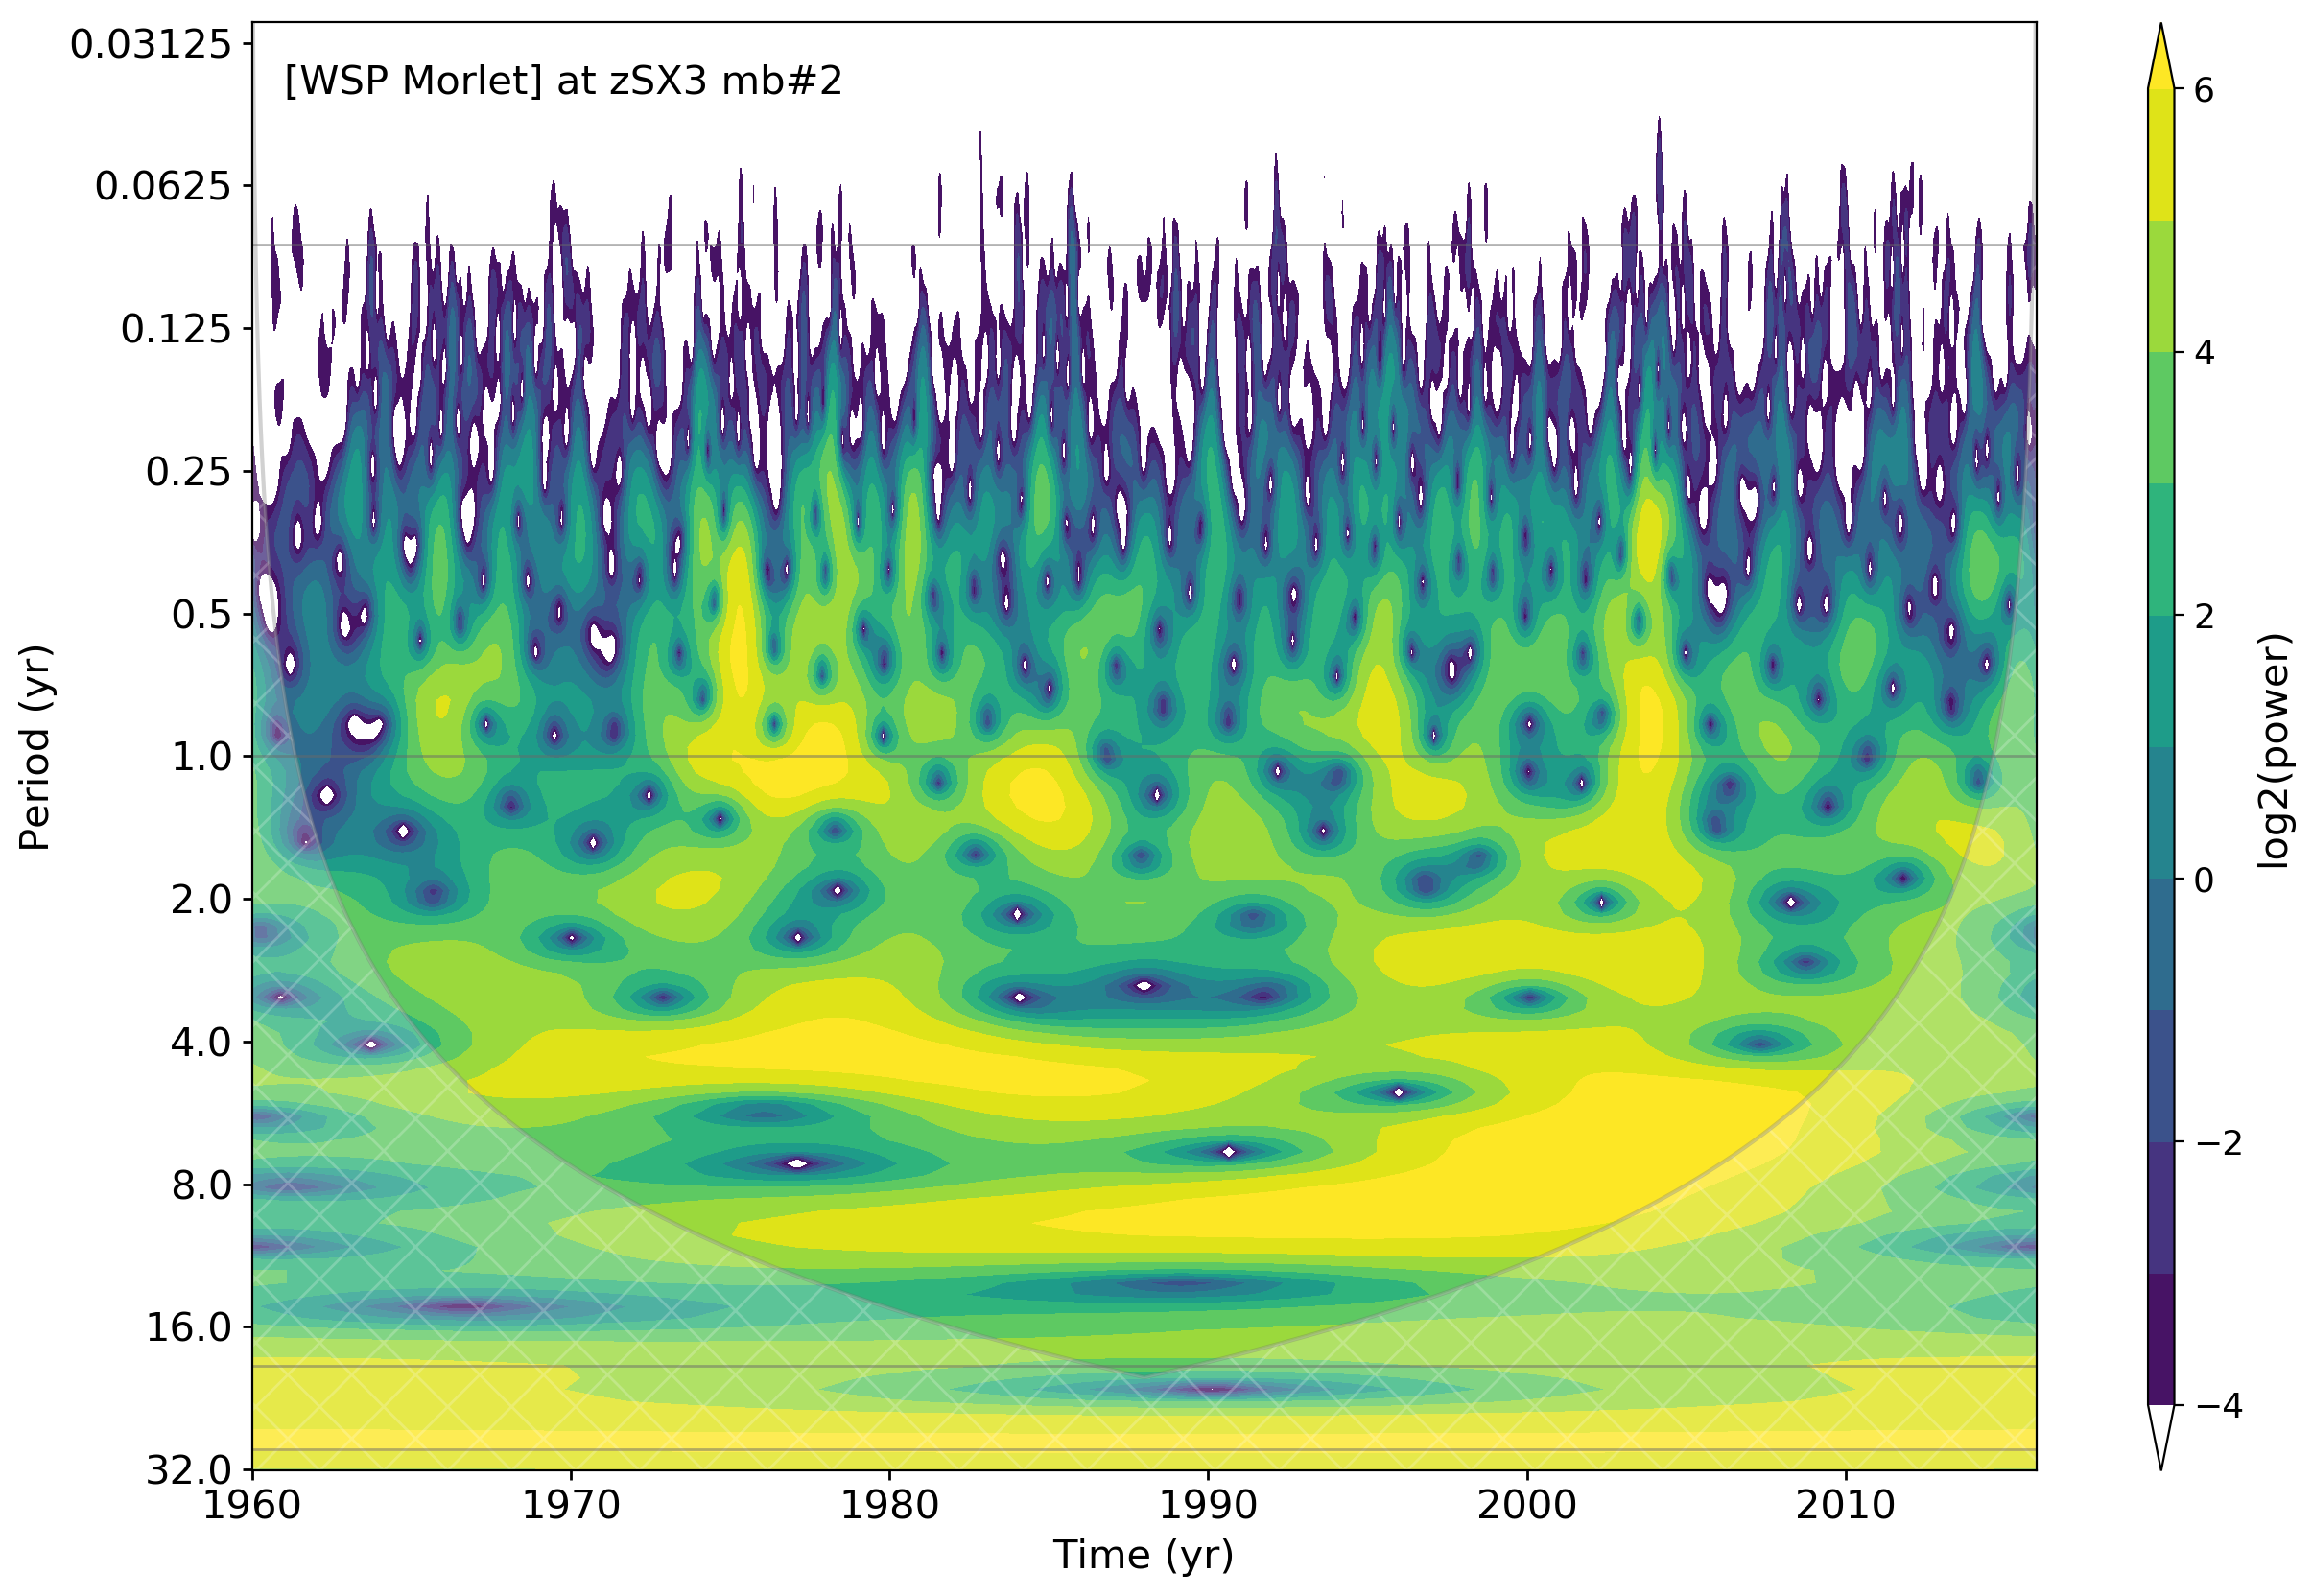

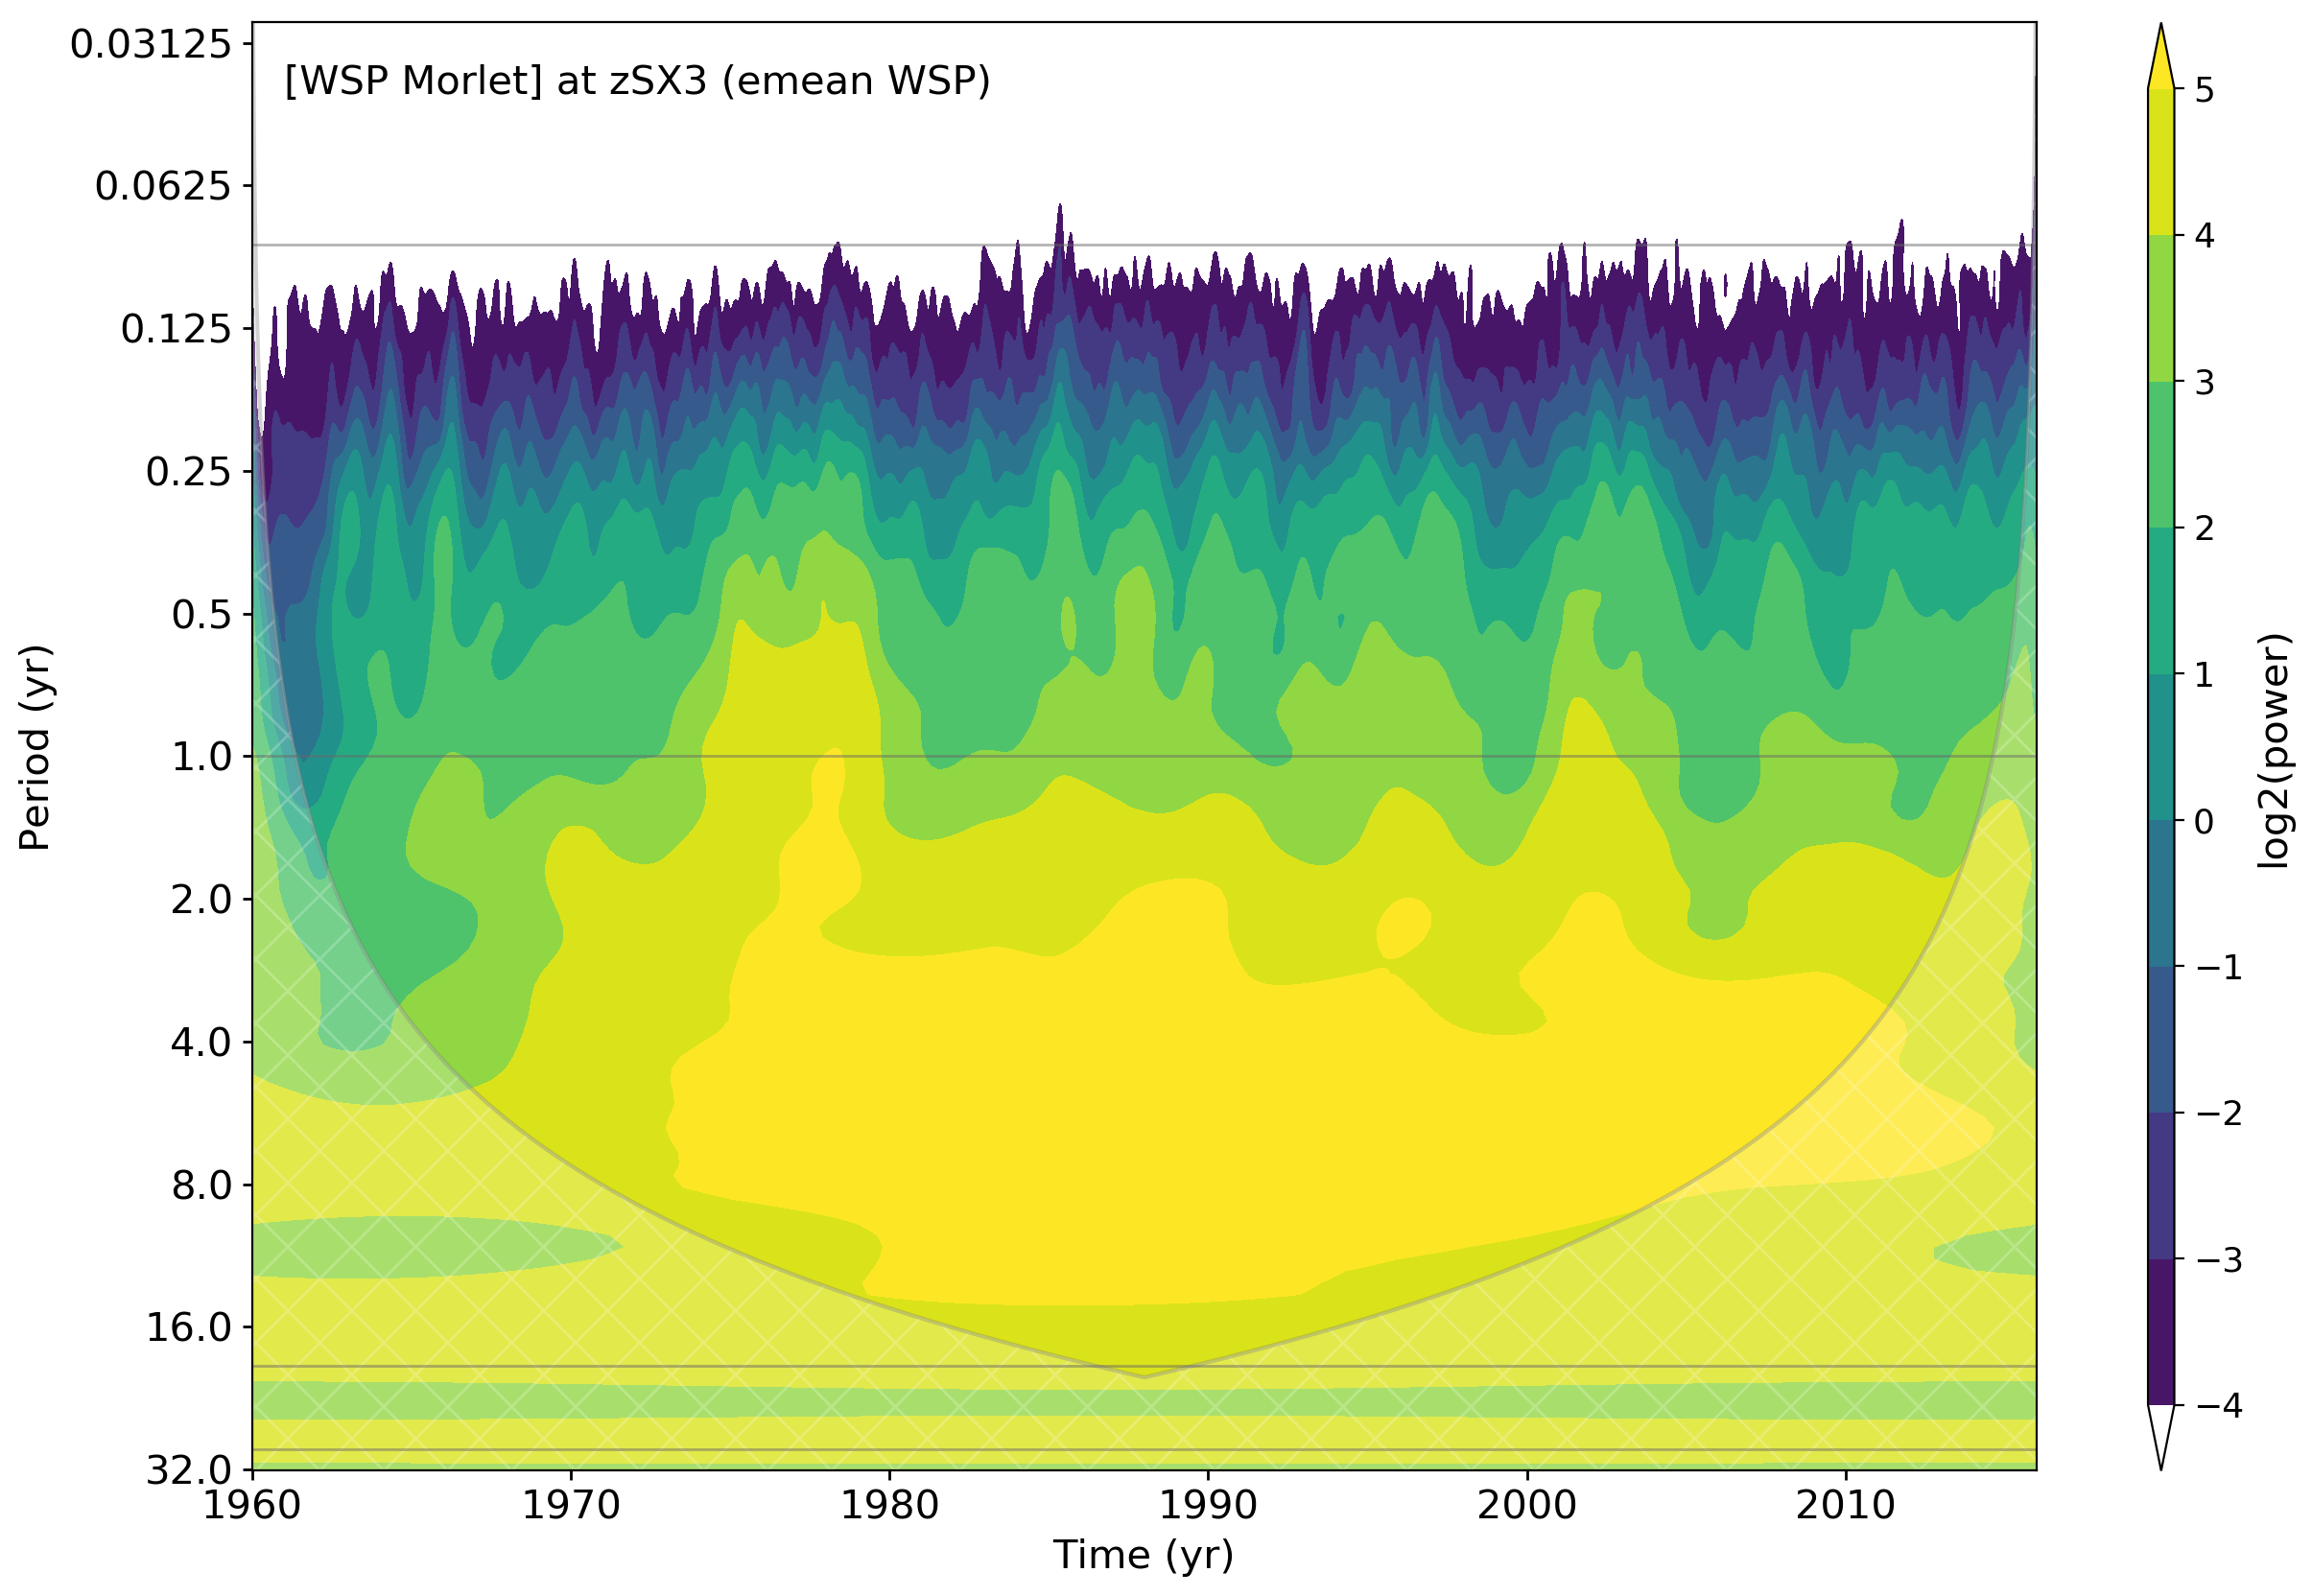

In [7]:
# number of timesteps
N = predat.time_counter.size

# time coordinate in x axis
dt=(1./73.)   # (every-5-day data)
t0=1960
t = np.arange(0, N) * dt + t0

#----- WAVELET PARAMETERS
mother = wavelet.Morlet(6)
s0 = 2. * dt  # Starting scale, in this case 2 * (1/73) years = 10 days
dj = 1. / 12.  # Twelve sub-octaves per octaves
J = (np.log2(N * dt / s0)) / dj # 7. / dj  # Seven powers of two with dj sub-octaves

# plots

ico=0 # initialize counter

# loop on the members 
print("Process members....")
for mbe in range(1,50):
    plt.close('all')
    ico=ico+1
    namefo="WSP_"+mother.name+"_"+SXloc+"_mb_"+str(mbe+1)
    label="[WSP "+mother.name+"] at "+SXloc+" mb#"+str(mbe+1)

    #----- extract DATA  for the given member
    dat = np.array(predat.sel(e=mbe))

    #----- NORMALIZATION and DETRENDING (LIN)
    # here: fit a one-degree polynomial function and then subtract it from the original data.
    p = np.polyfit(t - t0, dat, 1)
    dat_notrend = dat - np.polyval(p, t - t0)
    std = dat_notrend.std()  # Standard deviation
    var = std ** 2  # Variance
    dat_norm = dat_notrend / std  # Normalized dataset

    #----- WAVELET COMPUTATION
    wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J,
                                                          mother)
    # Normalized wavelet and Fourier equivalent periods for each wavelet scale
    power = (np.abs(wave)) ** 2
    period = 1. / freqs

    #----- PLOT individual wavelet
    fig = plotWaveSP(power,period,t,patho=diro,label=label,dtmin=0.03125,unitperiod='yr',unittime='yr')
    # Save fig in png, resolution dpi
    fig.savefig(diro+'%s.png' % namefo, facecolor=fig.get_facecolor(), edgecolor='none',dpi=dpifig,bbox_inches='tight', pad_inches=0)#

    # Sum over members
    if (ico==1):        
        powermean = power
        plt.show()
    else:
        powermean = power+powermean

# Compute average over the 50 members
powermean = (1./ico)*powermean
    
# Plot averaged wavelet sp
label="[WSP "+mother.name+"] at "+SXloc+" (emean WSP)"
namefo="WSP_"+mother.name+"_"+SXloc+"_emeamWSP"
plt.close("all")
fig = plotWaveSP(powermean,period,t,patho=diro,label=label,dtmin=0.03125,unitperiod='yr',unittime='yr')
plt.show()

# Save fig in png, resolution dpi
fig.savefig(diro+'WSP.%s.png' % namefo, facecolor=fig.get_facecolor(), edgecolor='none',dpi=dpifig,bbox_inches='tight', pad_inches=0)#


        
      
        
        